# 14a. Green color analysis U1474
Here we take the photos from IODP site U1474 and analyze their color. There is two steps, which are somewhat unrelated to each other. The first step normalizes the saturation to set it's min-max range for the entire core to something near 0-255. This has no impact on the color analysis, because we only use the raw core photos for that. But, this is useful for the human eye, in identifying what is really green in the photos and seeing what we are looking for.  
  
The second step uses the groups based on the Munsell Colors that we identified in Notebook 05 and applies them in the form of filters to the core photos here. This allows us to see in what range the greening in the core is, and identify the depths of green layers throughout the core splice. 

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
from PIL import Image
import os
import cv2 as cv

### Set paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Volumes/SanDisk.Data/IODPU1474CorePhotos/'
section_path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/SpliceSections/'
saturated_path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Saturated/'
lowres_raw='/Volumes/SanDisk.Data/IODPU1474CorePhotos/LowRes/Raw/'
lowres_sat='/Volumes/SanDisk.Data/IODPU1474CorePhotos/LowRes/Saturated/'
filtered_path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Filtered/Green/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'

### Import splice data

In [3]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv')
splice=splice[splice['Site']=='U1474']
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+
                              section_list['Sect'].map(str))
section_list=section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top depth CCSF (m)',
                                          'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom depth CCSF (m)'})

In [4]:
sections=section_list[(section_list['Top depth CCSF (m)']<205)&
                      (section_list['Sect']!='CC')]['SectionLabel'].reset_index(drop=True)

### Import core photos
(Full Resoluiton)

In [5]:
cpmd=pd.read_csv(data_path+'U1474/corePhotosMetadataU1474.csv')
cpmd['SectionLabel']=cpmd['Site']+cpmd['Hole']+'_'+cpmd['Core'].map(str)+cpmd['Type']+cpmd['Sect'].map(str)
iddrop=cpmd[(cpmd['SectionLabel']=='U1474F_6H2')&(cpmd['A/W']=='W')].index
cpmd=cpmd.drop(iddrop)
cpmd['Cropped image filename (JPEG)']=cpmd['Cropped image filename'].str[:-4]+'.jpeg'
cpmd.set_index('SectionLabel',inplace=True)
cpmd=cpmd[cpmd['Display status (T/F)']=='T']

In [6]:
def path_finder(section):
    if section[5]=='A':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474A-LSIMG/'
    elif section[5]=='B':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474B-LSIMG/'
    elif section[5]=='C':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474C-LSIMG/'
    elif section[5]=='D':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474D-LSIMG/'
    elif section[5]=='E':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474E-LSIMG/'
    else:
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474F-LSIMG/'
    return path

In [7]:
phot={}
start=time.time()
for i,s in enumerate(sections):
    clear_output(wait=True)
    path=path_finder(s)
    filename=cpmd.loc[s,'Cropped image filename'][:-4]+'-LSIMG.jpg'
    phot[s] = Image.open(path+filename)
    print(i,'/',len(sections))

532 / 533


## Filter Green
This is the part where we use the InRange function from OpenCV and apply the color groups we created in Notebook 04 Munsell Colors to identify the number of pixels at each depth increment that fit in those ranges.  
  
Input a section number and see how the process works.

In [8]:
# i=339
i=402 # demo sample
sect=sections[i]
file=cpmd.loc[sect,'Cropped image filename']

Load sample section

In [9]:
raw=cv.imread(section_path+file,1)

rgbraw=cv.cvtColor(raw,cv.COLOR_BGR2RGB)
hsv=cv.cvtColor(raw,cv.COLOR_BGR2HSV)

Load low res photo for graphing and do the same thing

In [10]:
l_raw=cv.imread(lowres_raw+file,1)
rgbl_raw=cv.cvtColor(l_raw,cv.COLOR_BGR2RGB)

Load groups we created earlier and normalize the range to fit OpenCV, which has a range of 0-179 for Hue, and 0-255 for saturation and value. 

In [11]:
groups=pd.read_csv(table_path+'Supplementary Table 4 - Green channels.csv',index_col='Code')
green_groups=groups.copy()
green_groups.loc[green_groups['Smin']==0,'Smin']=5
vs=['Hmin', 'Hmax', 'Smin', 'Smax', 'Vmin', 'Vmax']
green_groupsn=green_groups[vs]/np.array([360,360,100,100,100,100])*np.array([179,179,255,255,255,255])
green_lowlims=[tuple(green_groupsn.loc[n,['Hmin','Smin','Vmin']]) for n in green_groupsn.index]
green_highlims=[tuple(green_groupsn.loc[n,['Hmax','Smax','Vmax']]) for n in green_groupsn.index]

### Filter for each group
The code below goes through each group and applies the inRange function and saves them to a dictionary, filtered.

In [12]:
green_filtered={}
for i,n in enumerate(green_groups.index):
    clear_output(wait=True)
    green_filtered[n]=cv.inRange(hsv,green_lowlims[i],green_highlims[i])
    print('Filtering: ',i,'/',len(green_groups))

Filtering:  626 / 627


### Make depth series for each group
Dseries is another dictionary that sums across the width of the core to make an object resembing a depth series.  
**Attention!** This code takes a while to run. You don't need to do it unless you are interested in investigating the depth series for each channel individually below

In [15]:
green_dserieses=np.zeros((green_filtered['30-0-20'].shape[1],len(green_groups)))
for i,n in enumerate(green_groups.index):
    clear_output(wait=True)
    green_dserieses[:,i]=(green_filtered[n]/255).sum(axis=0)
    print('Serializing: ',i,'/',len(green_groups))

Serializing:  626 / 627


### Investigate Color Channels

In [16]:
df=pd.DataFrame(green_dserieses,columns=green_groups.index)

In [17]:
nlow=150 # demo figure
nhigh=250 # demo figure 

In [18]:
big_group=green_groups.iloc[nlow:nhigh].index

In [19]:
green_channel_codes=['40-30-30','40-30-40',
                     '50-20-30','50-20-40','50-30-20','50-40-20','50-40-30',
#                      '60-10-40',
                     '60-20-20','60-20-30','60-20-40','60-30-10','60-30-20','60-30-30',
                     '70-10-40','70-10-50','70-20-20','70-20-30','70-20-40','70-30-10',
                     '80-10-20','80-10-30','80-10-40','80-10-50',
                         '80-20-20', '80-20-30', '80-20-40', 
                     '90-0-30','90-0-40','90-0-50','90-10-20','90-10-30','90-10-40','90-10-50',
                         '90-20-20','90-20-30',
                     '100-0-20','100-0-30','100-0-40','100-0-50','100-10-20','100-10-30',
                         '100-10-40','100-20-20','100-20-30',
                     '110-0-30','110-0-40','110-0-50','110-10-20','110-10-30','110-10-40',
                     '120-0-30','120-0-40','120-10-20','120-10-30','120-10-40',
                     '130-0-30','130-0-40','130-10-20','130-10-30','130-10-40']

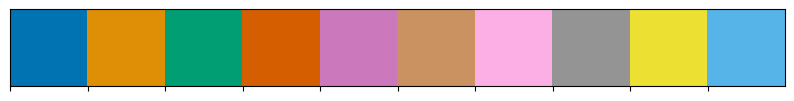

In [20]:
colors=sns.color_palette('colorblind').as_hex()
sns.palplot(colors)

In [21]:
import random

In [22]:
random_color_options=[0,1,3,4,5,6,7,8,9]
group_colors={}
for c in big_group:
    if c in green_channel_codes:
        group_colors[c]=colors[2]
    else:
        group_colors[c]=colors[random.choice(random_color_options)]
# group_colors={}
# for c in green_channel_codes:
#     group_colors[c]=colors[random.choice(random_color_options)]

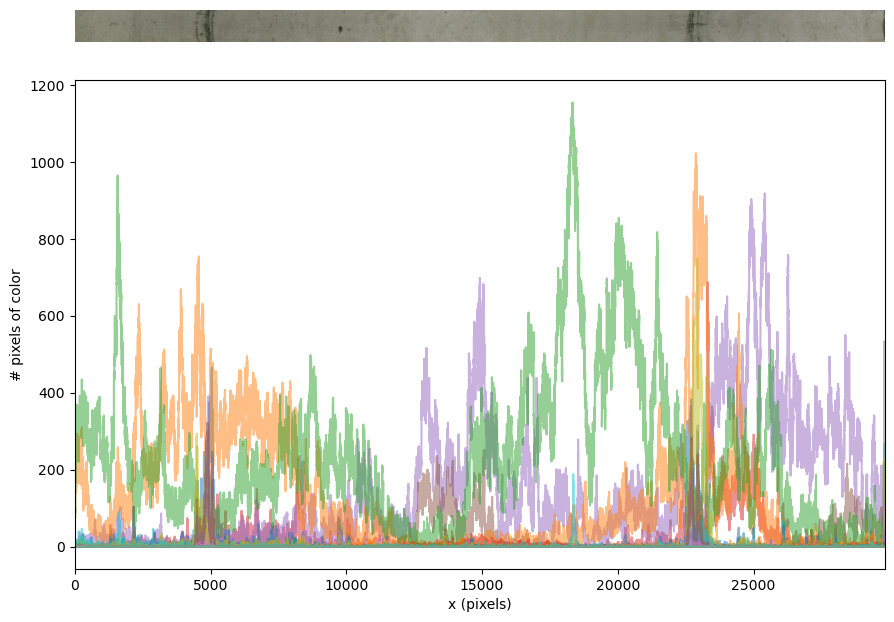

In [24]:
%matplotlib inline
fig=plt.figure(figsize=(9,7))
gs = gridspec.GridSpec(6, 1, figure=fig,hspace=.1,left=.05,right=.95,top=.95)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1:,:])
ax1.imshow(rgbl_raw)
ax1.axis('off');

for i,n in enumerate(range(nlow,nhigh)):
    ax2.plot(green_dserieses[:,n],label=n,alpha=.5)
# ax2.legend(loc='right')
ax2.set_ylabel('# pixels of color')
ax2.set_xlabel('x (pixels)');
ax2.set_xlim(0,len(green_dserieses[:,n]));

In [25]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
fig = make_subplots(rows=2,row_heights=[0.12, 0.88],vertical_spacing = 0.05)

fig.add_trace(px.imshow(rgbl_raw).data[0], row=1, col=1)

for i,g in enumerate(big_group):
    fig.add_trace(go.Scatter(x=df.index, y=df[big_group[i]],
                             mode='lines',name=big_group[i],
                             text=big_group[i],
                             line = dict(color=group_colors[g], width=1),
                             hovertemplate=big_group[i],
                             showlegend = False),
                             col=1,row=2)

# for i,g in enumerate(green_channel_codes):
#     fig.add_trace(go.Scatter(x=df.index, y=df[green_channel_codes[i]],
#                              mode='lines',name=green_channel_codes[i],
#                              text=green_channel_codes[i],
#                              line = dict(color=group_colors[g], width=1),
#                              hovertemplate=green_channel_codes[i],
#                              showlegend = False),
#                              col=1,row=2)

fig.update_layout(width=900,
                  height=400,
                  margin=dict(l=0, #left margin
                              r=0, #right margin
                              b=0, #bottom margin
                              t=0)) #top margin)

# fig.update_xaxes(range=[0, df.index.max()])
fig['layout']['xaxis1']['showticklabels']=False
fig['layout']['yaxis1']['showticklabels']=False


fig['layout']['xaxis2']['title']='Section Offset (x pixel position)'
fig['layout']['yaxis2']['title']='# Pixels in Channel'

# fig.show()
# fig.write_html(presentation_path+'M04_green_depth_series.html')
# fig.write_image(sup_figure_path+'Sup Figure 9 Green Depth Series Demo.png')
fig.write_image(sup_figure_path+'Extended Data Figure 5 Testing channels for green band sensitivity.png')

### Choose good color groups

In [25]:
green_channel_codes=['40-30-30','40-30-40',
                     '50-20-30','50-20-40','50-30-20','50-40-20','50-40-30',
#                      '60-10-40',
                     '60-20-20','60-20-30','60-20-40','60-30-10','60-30-20','60-30-30',
                     '70-10-40','70-10-50','70-20-20','70-20-30','70-20-40','70-30-10',
                     '80-10-20','80-10-30','80-10-40','80-10-50',
                         '80-20-20', '80-20-30', '80-20-40', 
                     '90-0-30','90-0-40','90-0-50','90-10-20','90-10-30','90-10-40','90-10-50',
                         '90-20-20','90-20-30',
                     '100-0-20','100-0-30','100-0-40','100-0-50','100-10-20','100-10-30',
                         '100-10-40','100-20-20','100-20-30',
                     '110-0-30','110-0-40','110-0-50','110-10-20','110-10-30','110-10-40',
                     '120-0-30','120-0-40','120-10-20','120-10-30','120-10-40',
                     '130-0-30','130-0-40','130-10-20','130-10-30','130-10-40']

In [26]:
green_channels=green_groups.loc[green_channel_codes].copy()
vs=['Hmin', 'Hmax', 'Smin', 'Smax', 'Vmin', 'Vmax']
green_channelsn=green_channels[vs]/np.array([360,360,100,100,100,100])*np.array([179,179,255,255,255,255])
green_lowlims=[tuple(green_channelsn.loc[n,['Hmin','Smin','Vmin']]) for n in green_channelsn.index]
green_highlims=[tuple(green_channelsn.loc[n,['Hmax','Smax','Vmax']]) for n in green_channelsn.index]

### Combine filters

In [27]:
green_record=green_filtered[green_channels.index[0]]
for i in green_channels.index[1:]:
    green_record=green_record|green_filtered[i]

In [28]:
hsvfilt=hsv.copy()
hsvfilt[:,:,1] = green_record
back = cv.cvtColor(hsvfilt, cv.COLOR_HSV2RGB)
back_bgr = cv.cvtColor(hsvfilt, cv.COLOR_HSV2BGR)

In [29]:
# cv.imwrite(sup_figure_path+'Sup Figure 11 Filtered Image.png', back_bgr)

In [30]:
height=green_record.shape[0]

Text(0.5, 0, 'Section Offset (x pixel position)')

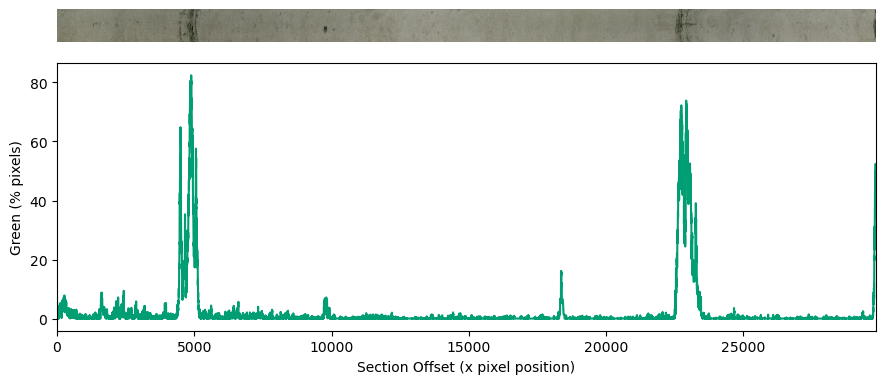

In [31]:
fig=plt.figure(figsize=(9,4))
gs = gridspec.GridSpec(5, 1, figure=fig,hspace=.1,left=.06,right=.97,top=.95)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1:,:])
ax1.imshow(rgbraw)
ax1.axis('off');
ax2.plot(green_record.sum(axis=0)/255/height*100,color=colors[2])
ax2.set_xlim(0,green_dserieses.shape[0]);
ax2.set_ylabel('Green (% pixels)')
ax2.set_xlabel('Section Offset (x pixel position)')
# fig.savefig(presentation_path+'M07_summed_green_depth_series.png',dpi=300)
# fig.savefig(sup_figure_path+'Sup Figure 12 Summed Green Intensity Depth Series.png',dpi=500)

## Export

In [32]:
def load(sect):
    img=cv.imread(section_path+cpmd.loc[sect,'Cropped image filename'],1)
    pxllen=img.shape[1]
    pxlwidth=img.shape[0]
    
    topCSFA=section_list.loc[section_list['SectionLabel']==sect,'Top depth CSF-A (m)'].values
    bottomCSFA=section_list.loc[section_list['SectionLabel']==sect,'Bottom depth CSF-A (m)'].values
    topCCSF=section_list.loc[section_list['SectionLabel']==sect,'Top depth CCSF (m)'].values
    bottomCCSF=section_list.loc[section_list['SectionLabel']==sect,'Bottom depth CCSF (m)'].values
    
    length=bottomCCSF-topCCSF
    depthsCCSF=np.linspace(topCCSF,bottomCCSF,pxllen).flatten()
    depthsCSFA=np.linspace(topCSFA,bottomCSFA,pxllen).flatten()
    offset=np.linspace(0,length*100,pxllen).flatten()
    pxl_mm=pxllen/length/1000
    depthpxl=pd.DataFrame({'pixel#':np.arange(0,pxllen,1),
                           'Depth CCSF (m)':depthsCCSF,
                           'Depth CSF-A (m)':depthsCSFA,
                           'Offset (cm)':offset}).set_index('Offset (cm)')
    doffsets=np.arange(0,length*100,.1)
    poffsets=depthpxl.reindex(doffsets,method='nearest')['pixel#'].values
    return img,pxllen,pxlwidth,pxl_mm,topCSFA,bottomCSFA,topCCSF,bottomCCSF,length,depthsCSFA,depthsCCSF,offset,doffsets,poffsets,depthpxl

In [33]:
def greenFilter(img,md):
    img,pxllen,pxlwidth,pxl_mm,topCSFA,bottomCSFA,topCCSF,bottomCCSF,length,depthsCSFA,depthsCCSF,offset,doffsets,poffsets,depthpxl=md
    
#     buffer_len=10 #mm
#     pxl_buffer=int(pxl_mm*10)
    
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    filtered={}
    for i,n in enumerate(green_channels.index):
        filtered[n]=cv.inRange(hsv,green_lowlims[i],green_highlims[i])

    dserieses=filtered.copy()
    for i,n in enumerate(green_channels.index):
        dserieses[n]=filtered[n].sum(axis=0)/255
#         dserieses[n][0:pxl_buffer]=0
#         dserieses[n][-pxl_buffer:]=0
        
    record=filtered[green_channels.index[0]].copy()
    for i in green_channels.index[1:]:
        record=record|filtered[i]
        
    dserieses['Green%']=record.sum(axis=0)/255
    
    hsvfilt=hsv.copy()
    hsvfilt[:,:,1] = record
    
    img_filt = cv.cvtColor(hsvfilt, cv.COLOR_HSV2BGR)
    return dserieses,img_filt

In [34]:
def toFrame(filtered,md):
    img,pxllen,pxlwidth,pxl_mm,topCSFA,bottomCSFA,topCCSF,bottomCCSF,length,depthsCSFA,depthsCCSF,offset,doffsets,poffsets,depthpxl=md
    dseries=pd.DataFrame({'Offset (cm)':offset})
    for key in filtered.keys():
        dseries[key]=filtered[key].copy()
    dseries['Offset rounded']=dseries['Offset (cm)'].round(1)
    dseries=dseries[['Offset rounded']+list(filtered.keys())].groupby('Offset rounded').sum()
    dseries=(dseries/pxl_mm[0]/pxlwidth*100).round(0)
    dseries['Exp']=361
    dseries['Site']=sect[:5]
    dseries['Hole']=sect[5]
    dseries['Core']=sect.split('_')[1][:-2]
    dseries['Type']=sect[-2]
    dseries['Section']=sect[-1]
    dseries['Offset (cm)']=dseries.index
    dseries['CSF-A Depth (m)']=topCSFA+dseries.index/100
    dseries['CCSF Depth (m)']=topCCSF+dseries.index/100
    collist=['Exp','Site','Hole','Core','Type','Section',
             'Offset (cm)','CSF-A Depth (m)','CCSF Depth (m)']+list(filtered.keys())
    dseries=dseries[collist]
    return dseries

In [37]:
green_data=data_path+'Green_Data/U1474/'

In [38]:
for i,sect in enumerate(sections):
    clear_output(wait=True)
    img,pxllen,pxlwidth,pxl_mm,topCSFA,bottomCSFA,topCCSF,bottomCCSF,length,depthsCSFA,depthsCCSF,offset,doffsets,poffsets,depthpxl=load(sect)
    md=[img,pxllen,pxlwidth,pxl_mm,topCSFA,bottomCSFA,topCCSF,bottomCCSF,length,depthsCSFA,depthsCCSF,offset,doffsets,poffsets,depthpxl]
    func_filtered,photo=greenFilter(img,md)
    func_dseries=toFrame(func_filtered,md)
    
    cv.imwrite(filtered_path+cpmd.loc[sect,'Cropped image filename'], photo)
    func_dseries.to_csv(green_data+sect+'.csv',index=False)
    print(i,'/',len(sections))

532 / 533


## Resize filtered and saturated photos

In [39]:
lowres='/Volumes/SanDisk.Data/IODPU1474CorePhotos/LowRes/'

In [40]:
def shrink_write(kind,section,shrinkfactor):
    if kind=='Saturated':
        path=saturated_path
    if kind=='Filtered':
        path=filtered_path
    photo = cv.imread(path+cpmd.loc[section,'Cropped image filename'])
    size=photo.shape
    newsize=tuple((int(size[1]/shrinkfactor),int(size[0]/shrinkfactor)))
    sphoto=cv.resize(photo,newsize,interpolation = cv.INTER_AREA)
    cv.imwrite(lowres+kind+'/'+cpmd.loc[section,'Cropped image filename'],sphoto)

In [41]:
start=time.time()
for i,s in enumerate(sections):
    clear_output(wait=True)
#     shrink_write('Saturated',s,15)
    shrink_write('Filtered',s,15)
    stop=time.time()-start
    if i/len(sections)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(sections))/60,2)
    print('Current progress: ',np.round(i/len(sections)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  99.81 %
Current run time:  2.84  minutes
Expected run time:  2.85  minutes


## Make spliced record
### Load section results

In [42]:
green=pd.DataFrame()
section_files=os.listdir(data_path+'Green_Data/U1474/')
# Create an empty list to store the data frames
data_frames = []

# Loop through each file, read it into a DataFrame, and append it to the list
for sf in section_files:
    df = pd.read_csv(data_path + 'Green_Data/U1474/' + sf)
    data_frames.append(df)

# Concatenate all data frames in the list into a single data frame
green = pd.concat(data_frames, ignore_index=True)
green['Core']=green['Core'].astype(str)
green['Section']=green['Section'].astype(str)
green['CoreLabel']=(green['Site'].astype(str)+green['Hole']+'_'+green['Core'].astype(str))
green['CoreLabel']=green['CoreLabel']
green=green.sort_values(by='CCSF Depth (m)')
green=green.reset_index()
green['SectionLabel']=(green['Site']+green['Hole']+'_'+
                       green['Core'].map(str)+green['Type']+
                       green['Section'].map(str))

In [43]:
channel_cols=green.columns[9:-2].tolist()

In [44]:
section_max_offsets=green.groupby('SectionLabel')['Offset (cm)'].max()

In [45]:
sect_green=green.set_index('SectionLabel')
sect_green['Section Length (cm)']=section_max_offsets

In [46]:
green['Section Length (cm)']=sect_green['Section Length (cm)'].values

In [47]:
end_problems=green[((green['Offset (cm)']<=0.5)|
                    (green['Offset (cm)']>=green['Section Length (cm)']-.5))&(green['Green%']>5)].index

In [48]:
green.loc[end_problems,channel_cols]=np.nan

In [49]:
green=green.drop(['index','SectionLabel','Section Length (cm)'],axis=1)

<Axes: xlabel='CSF-A Depth (m)'>

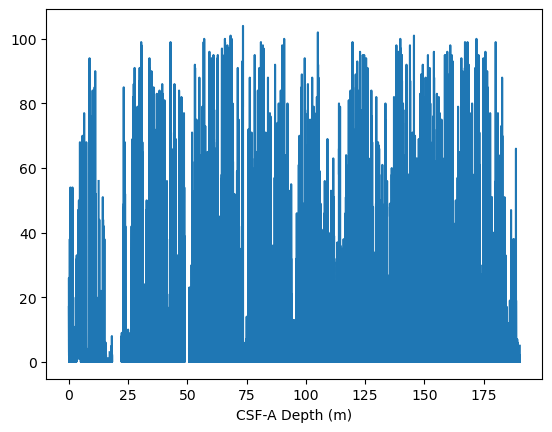

In [50]:
green[green['Hole']=='F'].set_index('CSF-A Depth (m)')['Green%'].plot()

### Splice results

In [51]:
spliceGreen=pd.DataFrame()
df=green
for i,core in enumerate(splice.CoreLabel):
    deeper=df.loc[df['CoreLabel']==core,'CCSF Depth (m)']>splice.loc[i,'Top depth CCSF (m)']
    shallower=df.loc[df['CoreLabel']==core,'CCSF Depth (m)']<splice.loc[i,'Bottom depth CCSF (m)']
    df.loc[df['CoreLabel']==core,'In Splice']=deeper&shallower
df_splice=df[df['In Splice']==True].copy()
df_splice.set_index('CCSF Depth (m)',inplace=True,drop=False)
df_splice=df_splice[df_splice.index.duplicated()==False]
df_splice.sort_index(inplace=True)
spliceGreen=df_splice

### Mask sand layers

In [52]:
sand_layers=pd.read_csv(table_path+'Supplementary Table X Site U1474 Sand Layers.csv')

In [56]:
greensand_path=filtered_path+cpmd.loc[sand_layers.iloc[0]['SectionLabel'],'Cropped image filename']
# img=cv.imread(greensand_path,1)
# cv.imwrite(sup_figure_path+'Sup Figure 13 Masking Sand Layers.png', img)

In [58]:
for l in sand_layers.index:
    base=sand_layers.loc[l,'Bottom depth CCSF (m)']
    top=sand_layers.loc[l,'Top depth CCSF (m)']
    spliceGreen.loc[top:base,channel_cols]=np.nan

Extra sand from coring disturbance

In [59]:
spliceGreen.loc[3.25:3.33,channel_cols]=np.nan

## Export green splice

In [60]:
keepcols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section', 'Offset (cm)',
          'CCSF Depth (m)']+green_channels.index.tolist()+['Green%']

In [61]:
spliceGreen[keepcols].to_csv(table_path+'Supplementary Table 5A - U1474 green intensity splice.csv',
                             index=False)